##  正则化 — 从0开始
本章从0开始介绍如何的正则化来应对过拟合问题。

### 高维线性回归
我们使用高维线性回归为例来引入一个过拟合问题。

具体来说我们使用如下的线性函数来生成每一个数据样本

$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \text{noise}$

这里噪音服从均值0和标准差为0.01的正态分布。

需要注意的是，我们用以上相同的数据生成函数来生成训练数据集和测试数据集。为了观察过拟合，我们特意把训练数据样本数设低，例如$n=20$，同时把维度升高，例如$p=200$。

In [18]:
import numpy as np

num_train = 20
num_test = 100
# 特征维数
num_inputs = 200

### 生成数据集
这里定义模型真实参数。

In [19]:
true_w = np.ones((num_inputs, 1)) * 0.01
true_b = 0.05

我们接着生成训练和测试数据集。



In [20]:
X = np.random.normal(size=(num_train + num_test, num_inputs))
y = np.matmul(X, true_w) + true_b
y += .01 * np.random.normal(size=y.shape)
X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回`batch_size`个随机的样本和对应的目标。我们通过python的`yield`来构造一个迭代器。

In [21]:
import random
batch_size = 1
def data_iter(X, y, num_examples, num_epochs, batch_size, shuffle=True):
    idx = list(range(num_examples*num_epochs))
    #random.shuffle(idx)
    batch_X = []
    batch_y = []
    for i in idx:
        i %= num_examples
        batch_X.append(X[i])
        batch_y.append(y[i])
        if len(batch_X) == batch_size:
            yield np.array(batch_X), np.array(batch_y)
            batch_X = []
            batch_y = []

### 初始化模型参数
下面我们随机初始化模型参数。之后训练时我们需要对这些参数求导来更新它们的值，所以我们需要创建它们的梯度。



In [22]:
def init_params():
    w = np.random.normal(size=(num_inputs, 1)) + 1
    #w = np.zeros((num_inputs, 1))
    b = np.zeros((1,))
    params = [w, b]
    return params

### $L_2$范数正则化
这里我们引入$L_2$范数正则化。不同于在训练时仅仅最小化损失函数(Loss)，我们在训练时其实在最小化

$\text{loss} + \lambda \sum_{p \in \textrm{params}}\|p\|_2^2。$

直观上，$L_2$范数正则化试图惩罚较大绝对值的参数值。下面我们定义$L_2$正则化。注意有些时候大家对偏移加罚，有时候不加罚。通常结果上两者区别不大。这里我们演示对偏移也加罚的情况：

In [23]:
def L2_penalty(w, b):
    return ((w**2).sum() + b**2) /2 


### 定义训练和测试
下面我们定义剩下的所需要的函数。这个跟之前的教程大致一样，主要是区别在于计算`loss`的时候我们加上了L2正则化，以及我们将训练和测试损失都画了出来。

In [24]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def net(X, w, b):
    return np.matmul(X, w) + b

def square_loss(yhat, y):
    return np.mean((yhat - y.reshape(yhat.shape)) ** 2 / 2)
    
def sgd(params, lambd, lr, batch_size, yhat, y, X):
    w = params[0]
    b = params[1]
    w = (1 - lr * lambd) * w - lr * grad_w(yhat, y, X, batch_size) 
    b = (1 - lr * lambd) * b - lr * grad_b(yhat, y, batch_size)
    return [w, b]

def grad_w(yhat, y, X, batch_size):
    return np.matmul(X.T, (yhat - y)) / batch_size

def grad_b(yhat, y, batch_size):
    return np.sum((yhat-y)) / batch_size

def test(net, params, X, y):
    #return square_loss(net(X, *params), y).mean().asscalar()
    return square_loss(net(X, params[0], params[1]), y) 

def train(lambd):
    num_epochs = 50
    learning_rate = 0.01
    batch_size = 10
    w, b = params = init_params()
    train_loss = []
    test_loss = []
    for batch_X, batch_y in data_iter(X_train, y_train, num_train, num_epochs, batch_size, shuffle=False):
        output = net(batch_X, w, b)
        loss = square_loss(output, batch_y) + lambd * L2_penalty(w, b)
        w, b = params = sgd(params, lambd, learning_rate, batch_size, output, batch_y, batch_X)
        train_loss.append(test(net, params, X_train, y_train))
        test_loss.append(test(net, params, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return 'learned w[:10]:', w[:10].T, 'learned b:', b

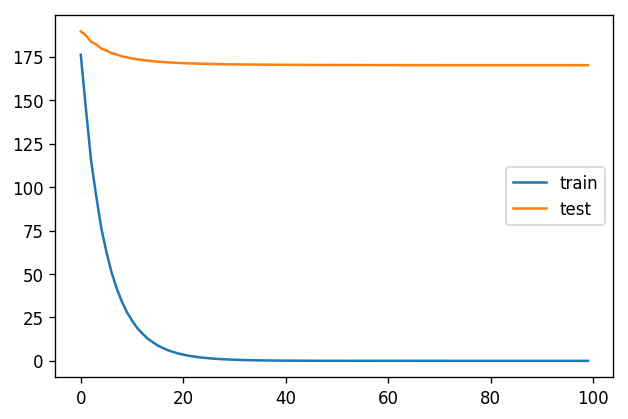

('learned w[:10]:',
 array([[1.35012378, 1.75643805, 1.5139215 , 0.27187214, 0.06569743,
         1.41660932, 1.80490346, 1.93053462, 2.11092912, 0.63803364]]),
 'learned b:',
 array([-0.17460435]))

In [25]:
train(0)


即便训练误差可以达到0.000000，但是测试数据集上的误差很高。这是典型的过拟合现象。

观察学习的参数。事实上，大部分学到的参数的绝对值比真实参数的绝对值要大一些。

### 使用正则化
下面我们重新初始化模型参数并设置一个正则化参数。



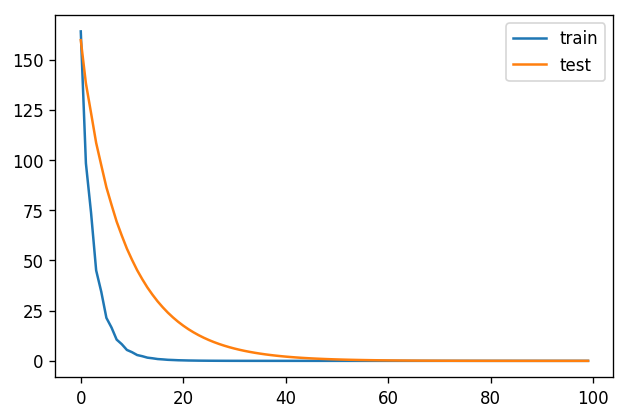

('learned w[:10]:',
 array([[ 0.00067986,  0.00799375,  0.01288328, -0.00069228,  0.00528985,
         -0.00115052,  0.00895132, -0.00553428,  0.00260429,  0.01165011]]),
 'learned b:',
 array([0.00383003]))

In [26]:
train(5)